# Galaxy Classification with Efficient Vision Transformer (Pytorch)

**Pre-Trained Vision Transformer (HuggingFace)**:

https://huggingface.co/docs/transformers/model_doc/vit


**Data:**

https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge


**References:**

1. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

2. https://pytorch.org/vision/stable/models.html

3. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

4. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

5. https://cs231n.github.io/transfer-learning/

6. https://github.com/joshualin24/vit-pytorch/blob/main/examples/galaxy_classification.ipynb



## Check GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-c240afa9-d360-407d-b0b8-ffdde19d2043)


## Install HuggingFace Vision Transformer (ViT)

In [ ]:
!pip install transformers

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# vision transformer
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor, ViTForImageClassification

cuda:0


In [ ]:
torch.manual_seed(0)

## Unzip images from Google Drive


In [ ]:
## The unzipping function
def unzipping(zip_file_name, dest_dir):
    """
    Arguments
        zip_file_name: (str) the file name of the zip file
        dest_dir: (str) the name of the destination folder
    """
    # check if the destination folder exists. Create one if not.
    #if not os.path.exists(dest_dir):
    #    os.makedirs(dest_dir)
    
    # unzipping
    zip_f = zipfile.ZipFile(zip_file_name, 'r')
    zip_f.extractall(path=dest_dir)
    zip_f.close()

In [ ]:
## directory on Google Drive
datasets_dir = 'drive/MyDrive/gz2_datasets'

## Unzip training, validation, and test images
unzipping(os.path.join(datasets_dir, 'images_train.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_valid.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_test.zip'), './')

## Custom Datasets

In [ ]:
## Custom Galaxy Zoo 2 Dataset
class GalaxyZooDataset(Dataset):
    """Galaxy Zoo Dataset"""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            images_dir (string): path to the dir containing all images
            transform (callable, optional): transform to apply
        """
        self.labels_df = pd.read_csv(csv_file)
        self.labels_df = self.labels_df[['galaxyID', 'label1']].copy()

        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        """
        Returns the size of the dataset
        """
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        Get the idx-th sample.
		Outputs the image (channel first) and the true label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # galaxy ID
        galaxyid = self.labels_df.iloc[idx, 0].astype(str)
		# path of the image
        image_path = os.path.join(self.images_dir, galaxyid + '.jpg')
		# read the image
        image = Image.open(image_path)
		# apply transform (optional)
        if self.transform is not None:
            image = self.transform(image)
		# read the true label
        label = int(self.labels_df.iloc[idx, 1])

        return image, label, int(galaxyid)

## Custom Transforms

In [ ]:
def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    
    return train_transform, valid_transform, test_transform

## Create Dataloaders

In [ ]:
"""
Data Loader
"""
# the batch size
BATCH_SIZE = 64

# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset('gz2_train.csv', 'images_train', train_transform)
data_valid = GalaxyZooDataset('gz2_valid.csv', 'images_valid', valid_transform)
data_test = GalaxyZooDataset('gz2_test.csv', 'images_test', test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("**Dataloaders**")
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))
print("===============================")

**Dataloaders**
Number of training data: 99808 (1560 batches)
Number of validation data: 24952 (390 batches)
Number of test data: 31191 (488 batches)


## Evaluation Function (HuggingFace ViT)

In [ ]:
def evaluate_model(model, loader, device):
    """
    Evaluate the model on the test data
    """

    # move to gpu
    model = model.to(device)

    # evaluation
    model.eval()

    # empty lists for results
    y_true = []
    y_pred = []
    y_label = []

    for images, labels, galaxy_id in loader:
        images = images.to(device)
        labels = labels.long().to(device)

        with torch.no_grad():
            outputs = model(images)
            pred_logits = outputs.logits
            _, pred_classes = torch.max(pred_logits.detach(), dim=1)

            y_true += torch.squeeze(labels.cpu()).tolist()
            y_pred += torch.squeeze(pred_classes).tolist()
            y_label += torch.squeeze(galaxy_id.cpu()).tolist()
    
    # create a DataFrame with columns 'GalaxyID', 'class', 'predicted labels'
    predict_df = pd.DataFrame(data={'GalaxyID': y_label, 'class': y_true, 'pred': y_pred})

    # galaxy classes
    gxy_labels = ['Round Elliptical',
                    'In-between Elliptical',
                    'Cigar-shaped Elliptical',
                    'Edge-on Spiral',
                    'Barred Spiral',
                    'Unbarred Spiral',
                    'Irregular',
                    'Merger']
    
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_df = pd.DataFrame(cm, index=gxy_labels, columns=gxy_labels)

    # accuracy of each class
    for c in range(8):
        print("Class {}: accuracy = {:.4f} ({})".format(c, cm[c,c]/sum(cm[c,:]), gxy_labels[c]))
    print("================")

    # accuracy
    acc = accuracy_score(y_true, y_pred)
    print("Total Accuracy = {:.4f}\n".format(acc))

    # recall
    recall = recall_score(y_true, y_pred, average='macro')
    print("Recall = {:.4f}\n".format(recall))

    # f1 score
    F1 = f1_score(y_true, y_pred, average='macro')
    print("F1 score = {:.4f}\n".format(F1))

    # plot confusion matrix
    sns.set(font_scale=1.6)
    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(cm_df, annot=True, fmt=".1%", cmap="YlGnBu", cbar=False, annot_kws={"size": 16})
    plt.show()

## Create Model and Load Weights (HuggingFace ViT)

In [ ]:
"""
Create ViT
"""
## Vision Transformer
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# change the last layer
model.classifier = nn.Linear(in_features=768, out_features=8, bias=True)

print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))

"""
Load Pretrained Weights (Current Best Model: 010822B)
"""

pth_filename = 'gz2_hug_vit_010822B.pth'
model.load_state_dict(torch.load(os.path.join('drive/MyDrive/gz2_datasets', pth_filename)))

Number of trainable parameters: 85804808


<All keys matched successfully>

## Check Performance

Class 0: accuracy = 0.9371 (Round Elliptical)
Class 1: accuracy = 0.8986 (In-between Elliptical)
Class 2: accuracy = 0.7948 (Cigar-shaped Elliptical)
Class 3: accuracy = 0.9245 (Edge-on Spiral)
Class 4: accuracy = 0.8849 (Barred Spiral)
Class 5: accuracy = 0.8065 (Unbarred Spiral)
Class 6: accuracy = 0.6970 (Irregular)
Class 7: accuracy = 0.8538 (Merger)
Total Accuracy = 0.8766

Recall = 0.8497

F1 score = 0.8564



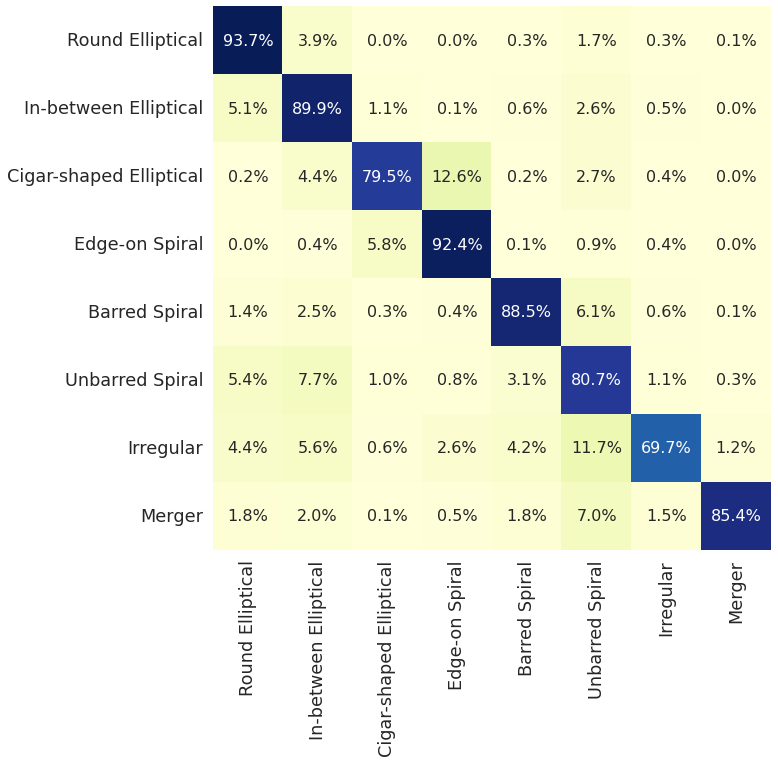

In [ ]:
# on training data
evaluate_model(model, train_loader, device)

Class 0: accuracy = 0.9295 (Round Elliptical)
Class 1: accuracy = 0.8824 (In-between Elliptical)
Class 2: accuracy = 0.7774 (Cigar-shaped Elliptical)
Class 3: accuracy = 0.9079 (Edge-on Spiral)
Class 4: accuracy = 0.8548 (Barred Spiral)
Class 5: accuracy = 0.7678 (Unbarred Spiral)
Class 6: accuracy = 0.5714 (Irregular)
Class 7: accuracy = 0.6577 (Merger)
Total Accuracy = 0.8491

Recall = 0.7936

F1 score = 0.8020



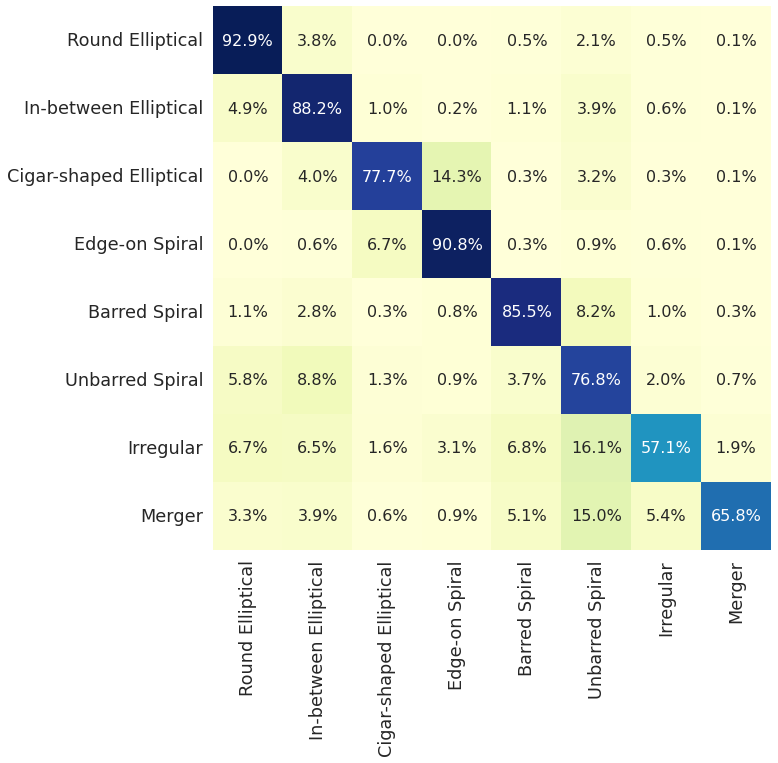

In [ ]:
# on validation data
evaluate_model(model, valid_loader, device)

Class 0: accuracy = 0.9304 (Round Elliptical)
Class 1: accuracy = 0.8846 (In-between Elliptical)
Class 2: accuracy = 0.7804 (Cigar-shaped Elliptical)
Class 3: accuracy = 0.8980 (Edge-on Spiral)
Class 4: accuracy = 0.8515 (Barred Spiral)
Class 5: accuracy = 0.7793 (Unbarred Spiral)
Class 6: accuracy = 0.5366 (Irregular)
Class 7: accuracy = 0.6560 (Merger)
Total Accuracy = 0.8500

Recall = 0.7896

F1 score = 0.7956



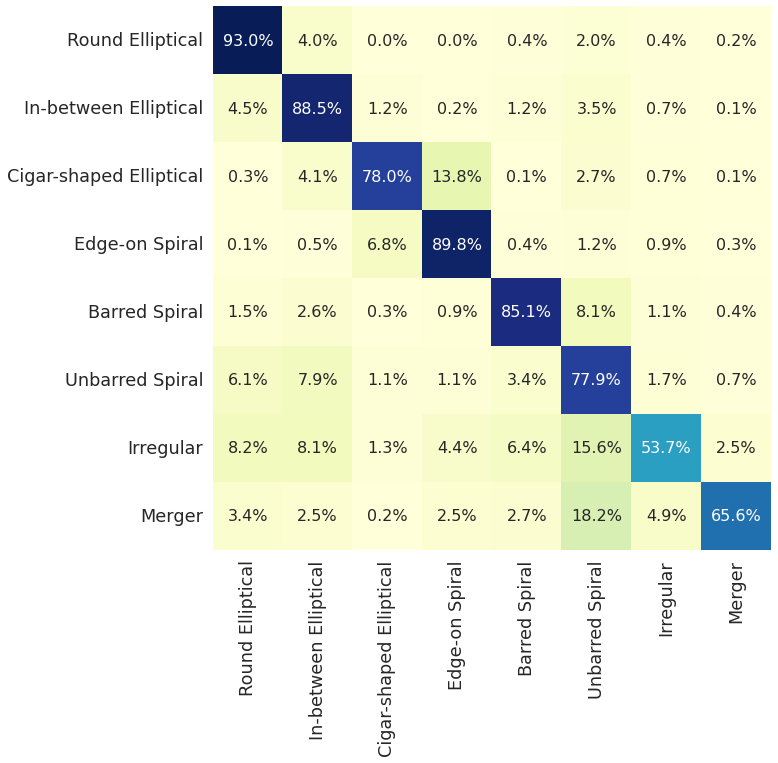

In [ ]:
# on test data
evaluate_model(model, test_loader, device)

## HuggingFace Vit - Feature Extraction

In [ ]:
def vit_extract_features(model, data_loader):
    """
    Extract the features from vit
    """
    # move to gpu
    model = model.to(device)

    # evaluation
    model.eval()

    # empty lists for results
    y_ids = []
    y_labels = []
    y_feature_vectors = []

    for images, labels, galaxy_id in data_loader:
        images = images.to(device)
        labels = labels.long().to(device)
        with torch.no_grad():
            return_dict = model.config.use_return_dict
            outputs = model.vit(images, return_dict=return_dict)
            sequence_output = outputs[0]
            x = sequence_output[:, 0, :].detach().cpu().tolist()
            
            # append to outputs
            y_ids.extend(galaxy_id.cpu().tolist())
            y_labels.extend(labels.cpu().tolist())
            y_feature_vectors.extend(x)
            
    df = pd.DataFrame({'galaxy_id': y_ids, 'label': y_labels, 'features': y_feature_vectors})
    
    for j in range(768):
        df["x"+str(j+1)] = df['features'].apply(lambda x: x[j])
    
    df = df.drop(columns=['features'])

    return df

In [ ]:
## Extract features
vit_base_train_f768 = vit_extract_features(model, train_loader)
vit_base_valid_f768 = vit_extract_features(model, valid_loader)
vit_base_test_f768 = vit_extract_features(model, test_loader)

In [ ]:
## Save to csv files on Google drive
vit_base_train_f768.to_csv(os.path.join('drive/MyDrive/gz2_datasets/features', 'vit_base_train_f768.csv'), index=False)
vit_base_valid_f768.to_csv(os.path.join('drive/MyDrive/gz2_datasets/features', 'vit_base_valid_f768.csv'), index=False)
vit_base_test_f768.to_csv(os.path.join('drive/MyDrive/gz2_datasets/features', 'vit_base_test_f768.csv'), index=False)